<a href="https://colab.research.google.com/github/MauriAleman35/Modelos-ERP-Ecommerce/blob/main/ModeloRegresionActual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carga y Validacion de datos

In [2]:
# MÓDULO 1: CARGA Y VALIDACIÓN DE DATOS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def cargar_datos(ruta_ventas='ventas.csv', ruta_productos='productos.csv',
                ruta_ventas_detalle='ventadetalles.csv', ruta_clientes='clientes.csv',
                verbose=True):
    """
    Carga los datos desde los archivos CSV con validación rigurosa

    Parameters:
    -----------
    ruta_ventas: str, ruta del archivo de ventas
    ruta_productos: str, ruta del archivo de productos
    ruta_ventas_detalle: str, ruta del archivo de detalle de ventas
    ruta_clientes: str, ruta del archivo de clientes
    verbose: bool, si se muestran mensajes de diagnóstico

    Returns:
    --------
    tuple: (ventas, productos, ventas_detalle, clientes)
    """
    try:
        # Cargar los datos con configuración específica para manejar diferentes formatos
        ventas = pd.read_csv(ruta_ventas, low_memory=False, parse_dates=['createdAT'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
        productos = pd.read_csv(ruta_productos, low_memory=False)
        ventas_detalle = pd.read_csv(ruta_ventas_detalle, low_memory=False)
        clientes = pd.read_csv(ruta_clientes, low_memory=False)

        if verbose:
            print(f"=== CARGA DE DATOS COMPLETADA ===")
            print(f"Ventas: {ventas.shape[0]:,} registros")
            print(f"Productos: {productos.shape[0]:,} registros")
            print(f"Ventas detalle: {ventas_detalle.shape[0]:,} registros")
            print(f"Clientes: {clientes.shape[0]:,} registros")

            # Estadísticas básicas para verificación rápida
            print(f"\n=== VERIFICACIÓN DE DATOS DE VENTAS ===")
            print(f"Total monetario en ventas: Bs. {ventas['total'].sum():,.2f}")
            print(f"Promedio por venta: Bs. {ventas['total'].mean():,.2f}")
            print(f"Venta mínima: Bs. {ventas['total'].min():,.2f}")
            print(f"Venta máxima: Bs. {ventas['total'].max():,.2f}")

            # Verificar distribución de fechas
            print(f"\n=== DISTRIBUCIÓN DE FECHAS ===")
            if pd.api.types.is_datetime64_any_dtype(ventas['createdAT']):
                # Asegurar que es datetime
                ventas['fecha_temp'] = ventas['createdAT']
            else:
                # Convertir a datetime si no lo es
                ventas['fecha_temp'] = pd.to_datetime(ventas['createdAT'], errors='coerce')

            # Calcular distribución por mes
            ventas['año_mes'] = ventas['fecha_temp'].dt.strftime('%Y-%m')
            conteo_por_mes = ventas['año_mes'].value_counts().sort_index()
            print("Distribución de ventas por mes:")
            for mes, conteo in conteo_por_mes.items():
                print(f"  {mes}: {conteo:,} ventas")

        # Verificación de integridad de los datos clave
        if 'total' not in ventas.columns:
            print("ADVERTENCIA: Columna 'total' no encontrada en datos de ventas")
        if '_id' not in ventas.columns:
            print("ADVERTENCIA: Columna '_id' no encontrada en datos de ventas")
        if 'cliente' not in ventas.columns:
            print("ADVERTENCIA: Columna 'cliente' no encontrada en datos de ventas")
        if 'createdAT' not in ventas.columns:
            print("ADVERTENCIA: Columna 'createdAT' no encontrada en datos de ventas")

        # Verificar fechas nulas
        if pd.api.types.is_datetime64_any_dtype(ventas['createdAT']):
            fechas_nulas = ventas['createdAT'].isna().sum()
            if fechas_nulas > 0:
                print(f"ADVERTENCIA: Hay {fechas_nulas} fechas nulas en los datos de ventas")

        # Verificar valores totales negativos o cero
        if (ventas['total'] <= 0).any():
            n_no_positivos = (ventas['total'] <= 0).sum()
            print(f"ADVERTENCIA: Hay {n_no_positivos} ventas con valores no positivos")

        # Verificar conexiones entre tablas
        if '_id' in ventas.columns and 'venta' in ventas_detalle.columns:
            # Verificar cuántos detalles tienen ventas válidas
            ventas_ids = set(ventas['_id'].astype(str))
            detalles_venta_ids = set(ventas_detalle['venta'].astype(str))
            detalles_con_ventas = detalles_venta_ids.intersection(ventas_ids)

            pct_match = len(detalles_con_ventas) / len(detalles_venta_ids) * 100 if detalles_venta_ids else 0
            print(f"\n=== VERIFICACIÓN DE RELACIONES ===")
            print(f"Detalles con ventas válidas: {len(detalles_con_ventas):,} de {len(detalles_venta_ids):,} ({pct_match:.1f}%)")

            if pct_match < 95:
                print("ADVERTENCIA: Menos del 95% de los detalles están asociados con ventas válidas")

        return ventas, productos, ventas_detalle, clientes

    except FileNotFoundError as e:
        print(f"ERROR: Archivo no encontrado: {e}")
        return None, None, None, None
    except pd.errors.EmptyDataError:
        print(f"ERROR: Al menos un archivo está vacío")
        return None, None, None, None
    except Exception as e:
        print(f"ERROR al cargar datos: {e}")
        return None, None, None, None


def validar_y_limpiar_datos(ventas, productos, ventas_detalle, clientes):
    """
    Realiza validaciones adicionales y limpieza de los datos

    Parameters:
    -----------
    ventas, productos, ventas_detalle, clientes: DataFrames con los datos

    Returns:
    --------
    tuple: (ventas_limpio, productos_limpio, ventas_detalle_limpio, clientes_limpio)
    """
    print("\n=== INICIANDO VALIDACIÓN Y LIMPIEZA DE DATOS ===")

    # Trabajar con copias para evitar modificar los originales
    ventas_limpio = ventas.copy()
    productos_limpio = productos.copy()
    ventas_detalle_limpio = ventas_detalle.copy()
    clientes_limpio = clientes.copy()

    # 1. Limpieza de ventas
    print("\nLimpiando tabla de ventas...")

    # Convertir fecha a datetime si no lo es
    if 'createdAT' in ventas_limpio.columns:
        if not pd.api.types.is_datetime64_any_dtype(ventas_limpio['createdAT']):
            ventas_limpio['createdAT'] = pd.to_datetime(ventas_limpio['createdAT'], errors='coerce')

    # Eliminar ventas sin fecha válida
    if 'createdAT' in ventas_limpio.columns:
        nulos_antes = ventas_limpio.shape[0]
        ventas_limpio = ventas_limpio.dropna(subset=['createdAT'])
        nulos_eliminados = nulos_antes - ventas_limpio.shape[0]
        if nulos_eliminados > 0:
            print(f"- Se eliminaron {nulos_eliminados} ventas sin fecha válida")

    # Eliminar ventas con total cero o negativo
    if 'total' in ventas_limpio.columns:
        invalidos_antes = ventas_limpio.shape[0]
        ventas_limpio = ventas_limpio[ventas_limpio['total'] > 0]
        invalidos_eliminados = invalidos_antes - ventas_limpio.shape[0]
        if invalidos_eliminados > 0:
            print(f"- Se eliminaron {invalidos_eliminados} ventas con total cero o negativo")

    # 2. Limpieza de ventas_detalle
    print("\nLimpiando tabla de ventas_detalle...")

    # Eliminar detalles sin cantidad o precio
    if 'cantidad' in ventas_detalle_limpio.columns and 'precio' in ventas_detalle_limpio.columns:
        invalidos_antes = ventas_detalle_limpio.shape[0]
        ventas_detalle_limpio = ventas_detalle_limpio[(ventas_detalle_limpio['cantidad'] > 0) &
                                                  (ventas_detalle_limpio['precio'] > 0)]
        invalidos_eliminados = invalidos_antes - ventas_detalle_limpio.shape[0]
        if invalidos_eliminados > 0:
            print(f"- Se eliminaron {invalidos_eliminados} detalles con cantidad o precio inválido")

    # 3. Verificar y mostrar estadísticas finales
    print("\n=== RESULTADOS DE LA LIMPIEZA ===")
    print(f"Ventas: {ventas_limpio.shape[0]:,} registros (se conservó {ventas_limpio.shape[0]/ventas.shape[0]*100:.1f}%)")
    print(f"Ventas detalle: {ventas_detalle_limpio.shape[0]:,} registros (se conservó {ventas_detalle_limpio.shape[0]/ventas_detalle.shape[0]*100:.1f}%)")
    print(f"Total monetario en ventas: Bs. {ventas_limpio['total'].sum():,.2f}")
    print(f"Promedio por venta: Bs. {ventas_limpio['total'].mean():,.2f}")

    # Verificar distribución de fechas después de limpieza
    print(f"\n=== DISTRIBUCIÓN DE FECHAS DESPUÉS DE LIMPIEZA ===")
    ventas_limpio['año_mes'] = ventas_limpio['createdAT'].dt.strftime('%Y-%m')
    conteo_por_mes = ventas_limpio['año_mes'].value_counts().sort_index()
    for mes, conteo in conteo_por_mes.items():
        print(f"  {mes}: {conteo:,} ventas")

    return ventas_limpio, productos_limpio, ventas_detalle_limpio, clientes_limpio


# Ejemplo de uso:
# ventas, productos, ventas_detalle, clientes = cargar_datos()
# ventas_limpio, productos_limpio, ventas_detalle_limpio, clientes_limpio = validar_y_limpiar_datos(ventas, productos, ventas_detalle, clientes)

Agregacion mensual

In [11]:
# MÓDULO 2: AGREGACIÓN MENSUAL

import pandas as pd
import numpy as np
from datetime import datetime

def agregar_ventas_diarias(ventas, ventas_detalle=None, incluir_detalles=False):
    """
    Agrega ventas a nivel diario directamente desde la tabla de ventas

    Parameters:
    -----------
    ventas: DataFrame con datos de ventas
    ventas_detalle: DataFrame con detalles de ventas (opcional)
    incluir_detalles: bool, si se incluyen métricas detalladas

    Returns:
    --------
    DataFrame con ventas agregadas por día
    """
    print("\n=== AGREGANDO VENTAS DIARIAS ===")

    # Verificar que ventas tiene las columnas necesarias
    if 'createdAT' not in ventas.columns or 'total' not in ventas.columns:
        print("ERROR: Las columnas requeridas no están en el DataFrame de ventas")
        return None

    # Asegurar que la fecha es datetime
    ventas = ventas.copy()
    if not pd.api.types.is_datetime64_any_dtype(ventas['createdAT']):
        ventas['createdAT'] = pd.to_datetime(ventas['createdAT'], errors='coerce')

    # Extraer solo fecha (sin hora)
    ventas['fecha'] = ventas['createdAT'].dt.date.astype('datetime64[ns]')

    # Agregación básica por día
    agg_dict = {'total': 'sum', '_id': 'count'}

    # Agregar columnas adicionales si están disponibles
    if 'envio' in ventas.columns:
        agg_dict['envio'] = 'sum'
    if 'cliente' in ventas.columns:
        agg_dict['cliente'] = 'nunique'

    # Agregar por día
    ventas_diarias = ventas.groupby('fecha').agg(agg_dict).reset_index()

    # Renombrar columnas para claridad
    ventas_diarias = ventas_diarias.rename(columns={
        '_id': 'num_ventas',
        'cliente': 'clientes_unicos'
    })

    # Si se incluyen detalles de ventas
    if incluir_detalles and ventas_detalle is not None:
        # Asegurar que ventas_detalle tiene las columnas necesarias
        if 'venta' not in ventas_detalle.columns:
            print("ADVERTENCIA: No se puede incluir detalles (falta columna 'venta')")
        else:
            try:
                # Unir detalles con ventas para obtener la fecha
                ventas_id_fecha = ventas[['_id', 'fecha']]
                ventas_id_fecha = ventas_id_fecha.rename(columns={'_id': 'id_venta'})

                # Asegurar que los tipos son consistentes para el join
                ventas_detalle = ventas_detalle.copy()
                ventas_detalle['venta'] = ventas_detalle['venta'].astype(str)
                ventas_id_fecha['id_venta'] = ventas_id_fecha['id_venta'].astype(str)

                # Unir para obtener fecha
                detalles_con_fecha = pd.merge(
                    ventas_detalle,
                    ventas_id_fecha,
                    left_on='venta',
                    right_on='id_venta',
                    how='inner'
                )

                # Calcular métricas adicionales por día
                detalles_agg = detalles_con_fecha.groupby('fecha').agg({
                    'producto': 'nunique',
                    'cantidad': 'sum',
                }).reset_index()

                # Renombrar columnas
                detalles_agg = detalles_agg.rename(columns={
                    'producto': 'productos_unicos',
                    'cantidad': 'unidades_vendidas'
                })

                # Unir con ventas diarias
                ventas_diarias = pd.merge(ventas_diarias, detalles_agg, on='fecha', how='left')

                # Rellenar valores faltantes
                if 'productos_unicos' in ventas_diarias.columns:
                    ventas_diarias['productos_unicos'] = ventas_diarias['productos_unicos'].fillna(0).astype(int)
                if 'unidades_vendidas' in ventas_diarias.columns:
                    ventas_diarias['unidades_vendidas'] = ventas_diarias['unidades_vendidas'].fillna(0).astype(int)

            except Exception as e:
                print(f"ADVERTENCIA: Error al incluir detalles: {e}")

    # Calcular ticket promedio
    if 'num_ventas' in ventas_diarias.columns and ventas_diarias['num_ventas'].sum() > 0:
        ventas_diarias['ticket_promedio'] = ventas_diarias['total'] / ventas_diarias['num_ventas']
        ventas_diarias['ticket_promedio'] = ventas_diarias['ticket_promedio'].fillna(0)

    # Asegurar que no hay fechas duplicadas
    if ventas_diarias['fecha'].duplicated().any():
        print("ADVERTENCIA: Hay fechas duplicadas en los resultados")

    print(f"- Procesados datos para {len(ventas_diarias)} días")
    print(f"- Rango de fechas: {ventas_diarias['fecha'].min()} a {ventas_diarias['fecha'].max()}")
    print(f"- Total ventas: Bs. {ventas_diarias['total'].sum():,.2f}")

    return ventas_diarias

def contar_ventas_mensual_simple():
     # Crear un DataFrame con los datos visibles del CSV
    # En tu caso, usarás: df = pd.read_csv('ventas.csv')
    df = pd.read_csv('ventas.csv')

    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['createdAT'])

    # Extraer año y mes
    df['año'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month

    # Agrupar por año y mes, y sumar la columna total
    ventas_mensuales = df.groupby(['año', 'mes'])['total'].sum().reset_index()

    # Añadir nombre del mes
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
             7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
    ventas_mensuales['nombre_mes'] = ventas_mensuales['mes'].map(meses)

    # Ordenar por año y mes
    ventas_mensuales = ventas_mensuales.sort_values(['año', 'mes'])

    # Mostrar resultados
    print("\n=== TOTALES MENSUALES DE VENTAS (CÁLCULO DIRECTO) ===")
    print("=======================================================")
    total_general = 0

    for _, row in ventas_mensuales.iterrows():
        print(f"{row['nombre_mes']:10} {row['año']} | Bs. {row['total']:,.2f}")
        total_general += row['total']

    print("=======================================================")
    print(f"TOTAL GENERAL: Bs. {total_general:,.2f}")

    return ventas_mensuales
def agregar_ventas_mensuales(ventas):
    """
    Agrega ventas a nivel mensual con múltiples métricas

    Parameters:
    -----------
    ventas_diarias: DataFrame con ventas diarias (preferido)
    ventas: DataFrame con datos de ventas originales (alternativa)

    Returns:
    --------
    DataFrame con ventas agregadas por mes
    """
    """
    Agrega ventas a nivel mensual directamente del archivo ventas.csv
    sin joins que puedan filtrar datos

    Parameters:
    -----------
    ventas: DataFrame de ventas cargado directamente de ventas.csv

    Returns:
    --------
    DataFrame con ventas agregadas por mes
    """
    print("\n=== AGREGACIÓN MENSUAL DIRECTA (CORREGIDA) ===")

    # Verificar que tenemos las columnas necesarias
    if 'createdAT' not in ventas.columns or 'total' not in ventas.columns:
        print("ERROR: Las columnas requeridas no están en el DataFrame de ventas")
        return None

    # Asegurar que la fecha es datetime
    ventas = ventas.copy()
    if not pd.api.types.is_datetime64_any_dtype(ventas['createdAT']):
        ventas['fecha'] = pd.to_datetime(ventas['createdAT'], errors='coerce')
    else:
        ventas['fecha'] = ventas['createdAT']

    # Extraer año y mes
    ventas['año'] = ventas['fecha'].dt.year
    ventas['mes'] = ventas['fecha'].dt.month

    # Mostrar estadísticas antes de agrupar para verificación
    print(f"Total en datos originales: Bs. {ventas['total'].sum():,.2f}")
    print(f"Número total de registros: {len(ventas):,}")

    # Crear clave año-mes para agrupación precisa
    ventas['año_mes'] = ventas['fecha'].dt.strftime('%Y-%m')

    # IMPORTANTE: Contar registros por mes antes de agrupar
    registros_por_mes = ventas.groupby('año_mes').size().reset_index(name='num_registros')

    # Agrupar por mes con suma explícita de 'total'
    ventas_mes = ventas.groupby(['año_mes', 'año', 'mes']).agg({
        'total': 'sum',
        '_id': 'count',
        'cliente': pd.Series.nunique if 'cliente' in ventas.columns else 'count'
    }).reset_index()

    # Renombrar columnas para claridad
    ventas_mes = ventas_mes.rename(columns={
        '_id': 'num_ventas',
        'cliente': 'clientes_unicos'
    })

    # Mapear nombres de meses
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
             7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
    ventas_mes['nombre_mes'] = ventas_mes['mes'].map(meses)

    # Ordenar cronológicamente
    ventas_mes = ventas_mes.sort_values(['año', 'mes'])

    # Mostrar detalle de ventas mensuales
    print("\nDesglose de ventas mensuales (CORREGIDO):")
    print("============================================")
    for idx, row in ventas_mes.iterrows():
        registros = registros_por_mes[registros_por_mes['año_mes'] == row['año_mes']]['num_registros'].iloc[0]
        print(f"  {row['nombre_mes']:<10} {row['año']} | Bs. {row['total']:13,.2f} | {row['num_ventas']:5} ventas | {registros:5} registros")
    print("============================================")

    print("\nEstadísticas:")
    print(f"  Media mensual: Bs. {ventas_mes['total'].mean():,.2f}")
    print(f"  Total acumulado: Bs. {ventas_mes['total'].sum():,.2f}")
    print(f"  Mínimo: Bs. {ventas_mes['total'].min():,.2f} ({ventas_mes.loc[ventas_mes['total'].idxmin(), 'nombre_mes']} {ventas_mes.loc[ventas_mes['total'].idxmin(), 'año']})")
    print(f"  Máximo: Bs. {ventas_mes['total'].max():,.2f} ({ventas_mes.loc[ventas_mes['total'].idxmax(), 'nombre_mes']} {ventas_mes.loc[ventas_mes['total'].idxmax(), 'año']})")

    # Calcular ticket promedio
    ventas_mes['ticket_promedio'] = ventas_mes['total'] / ventas_mes['num_ventas']
    ventas_mes['ticket_promedio'] = ventas_mes['ticket_promedio'].fillna(0)

    # Variables cíclicas
    ventas_mes['mes_sin'] = np.sin(2 * np.pi * ventas_mes['mes'] / 12)
    ventas_mes['mes_cos'] = np.cos(2 * np.pi * ventas_mes['mes'] / 12)

    # Trimestre
    ventas_mes['trimestre'] = ((ventas_mes['mes'] - 1) // 3) + 1

    return ventas_mes


def completar_fechas_faltantes(df, nivel='diario'):
    """
    Completa fechas faltantes en datasets de ventas agregadas

    Parameters:
    -----------
    df: DataFrame con ventas diarias o mensuales
    nivel: str, 'diario' o 'mensual'

    Returns:
    --------
    DataFrame con serie temporal completa
    """
    print(f"\n=== COMPLETANDO FECHAS FALTANTES (NIVEL {nivel.upper()}) ===")

    df = df.copy()

    if nivel == 'diario':
        if 'fecha' not in df.columns:
            print("ERROR: Columna 'fecha' no encontrada")
            return df

        # Encontrar rango de fechas
        fecha_min = df['fecha'].min()
        fecha_max = df['fecha'].max()

        # Crear serie completa de fechas
        todas_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')
        df_completo = pd.DataFrame({'fecha': todas_fechas})

        # Unir con datos existentes
        df_completo = pd.merge(df_completo, df, on='fecha', how='left')

        # Rellenar valores faltantes
        columnas_numericas = df_completo.select_dtypes(include=['number']).columns
        df_completo[columnas_numericas] = df_completo[columnas_numericas].fillna(0)

        print(f"- Serie temporal completada: {len(df_completo)} días")
        print(f"- Días sin datos originales: {len(df_completo) - len(df)}")

    elif nivel == 'mensual':
        if 'año' not in df.columns or 'mes' not in df.columns:
            print("ERROR: Columnas 'año' y 'mes' no encontradas")
            return df

        # Encontrar rango de fechas
        fecha_min = f"{df['año'].min()}-{df['mes'].min():02d}-01"
        ultimo_año = df['año'].max()
        ultimo_mes = df['mes'].max()
        fecha_max = f"{ultimo_año}-{ultimo_mes:02d}-01"

        # Convertir a datetime
        fecha_min = pd.to_datetime(fecha_min)
        fecha_max = pd.to_datetime(fecha_max)

        # Crear serie completa de fechas mensuales
        todas_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='MS')
        df_completo = pd.DataFrame({'fecha_temp': todas_fechas})

        # Extraer año y mes
        df_completo['año'] = df_completo['fecha_temp'].dt.year
        df_completo['mes'] = df_completo['fecha_temp'].dt.month

        # Unir con datos existentes
        df_completo = pd.merge(df_completo, df, on=['año', 'mes'], how='left')

        # Rellenar valores faltantes
        columnas_numericas = df_completo.select_dtypes(include=['number']).columns
        columnas_numericas = [col for col in columnas_numericas if col not in ['año', 'mes']]
        df_completo[columnas_numericas] = df_completo[columnas_numericas].fillna(0)

        # Añadir nombre del mes para los nuevos registros
        meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
        df_completo['nombre_mes'] = df_completo['mes'].map(meses)

        # Crear columna año-mes para los nuevos registros
        df_completo['año_mes'] = df_completo['año'].astype(str) + '-' + df_completo['mes'].astype(str).str.zfill(2)

        # Eliminar columna temporal
        df_completo = df_completo.drop('fecha_temp', axis=1)

        print(f"- Serie temporal completada: {len(df_completo)} meses")
        print(f"- Meses sin datos originales: {len(df_completo) - len(df)}")

    else:
        print(f"ERROR: Nivel '{nivel}' no válido. Use 'diario' o 'mensual'")
        return df

    return df_completo


# Ejemplo de uso:
# ventas_diarias = agregar_ventas_diarias(ventas_limpio, ventas_detalle_limpio, incluir_detalles=True)
# ventas_mensuales = agregar_ventas_mensuales(ventas_diarias)
# ventas_mensuales_completo = completar_fechas_faltantes(ventas_mensuales, nivel='mensual')

Visualización y Exploración

In [12]:
# MÓDULO 3: VISUALIZACIÓN Y EXPLORACIÓN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

def visualizar_ventas_mensuales(ventas_mensuales):
    """
    Visualiza las ventas mensuales con múltiples gráficos informativos
    Versión robusta que verifica columnas disponibles
    """
    if ventas_mensuales is None or len(ventas_mensuales) == 0:
        print("ERROR: No hay datos para visualizar")
        return

    print("\n=== VISUALIZANDO VENTAS MENSUALES ===")

    # Verificar columnas mínimas necesarias
    columnas_requeridas = ['año', 'mes', 'nombre_mes', 'total']
    columnas_faltantes = [col for col in columnas_requeridas if col not in ventas_mensuales.columns]
    if columnas_faltantes:
        print(f"ERROR: Faltan columnas requeridas: {columnas_faltantes}")
        return

    # 1. Gráfico de barras con ventas mensuales
    fig = px.bar(
        ventas_mensuales,
        x='nombre_mes',
        y='total',
        color='año',
        text_auto='.2s',
        title="Ventas Mensuales",
        labels={"total": "Ventas (Bs)", "nombre_mes": "Mes", "año": "Año"},
        height=500
    )

    # Configurar el orden de los meses
    meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                  'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    fig.update_xaxes(categoryorder='array', categoryarray=meses_orden)

    # Mejoras de formato
    fig.update_layout(
        xaxis_title="Mes",
        yaxis_title="Ventas (Bs)",
        legend_title="Año",
        barmode='group'
    )

    # Mostrar el gráfico
    fig.show()

    # 2. Gráfico de línea para tendencia temporal
    df_temp = ventas_mensuales.copy()
    # Crear fecha si no existe
    if 'fecha' not in df_temp.columns:
        df_temp['fecha'] = pd.to_datetime(df_temp['año'].astype(str) + '-' +
                                         df_temp['mes'].astype(str).str.zfill(2) + '-01')

    fig = px.line(
        df_temp,
        x='fecha',
        y='total',
        markers=True,
        title="Tendencia de Ventas Mensuales",
        labels={"total": "Ventas (Bs)", "fecha": "Fecha"},
        height=500
    )

    # Añadir etiquetas de datos
    fig.update_traces(texttemplate='Bs. %{y:,.0f}', textposition='top center')

    # Añadir promedio móvil de 3 meses si hay suficientes datos
    if len(df_temp) >= 3:
        df_temp['promedio_movil'] = df_temp['total'].rolling(window=3, min_periods=1).mean()
        fig.add_scatter(
            x=df_temp['fecha'],
            y=df_temp['promedio_movil'],
            mode='lines',
            name='Promedio móvil (3 meses)',
            line=dict(color='red', dash='dash')
        )

    # Mejoras de formato
    fig.update_layout(
        xaxis_title="Fecha",
        yaxis_title="Ventas (Bs)",
        legend_title="Métrica",
        hovermode="x unified"
    )

    # Mostrar el gráfico
    fig.show()

    # 3. Gráfico de distribución de ventas por mes (todos los años)
    fig = px.box(
        ventas_mensuales,
        x='nombre_mes',
        y='total',
        title="Distribución de Ventas por Mes",
        labels={"total": "Ventas (Bs)", "nombre_mes": "Mes"},
        height=500
    )

    # Configurar el orden de los meses
    fig.update_xaxes(categoryorder='array', categoryarray=meses_orden)

    # Mejoras de formato
    fig.update_layout(
        xaxis_title="Mes",
        yaxis_title="Ventas (Bs)"
    )

    # Mostrar el gráfico
    fig.show()

    # 4. Heatmap de ventas mensuales (si hay múltiples años)
    años_unicos = ventas_mensuales['año'].nunique()

    if años_unicos > 1:
        # Crear pivot para el heatmap
        pivot_data = ventas_mensuales.pivot(index='mes', columns='año', values='total')

        # Reindexar para asegurar todos los meses (1-12)
        todos_meses = list(range(1, 13))
        pivot_data = pivot_data.reindex(todos_meses)

        # Crear matriz de anotaciones
        annotations = pivot_data.applymap(lambda x: f'Bs. {x:,.0f}' if not pd.isna(x) else '')

        # Crear heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            pivot_data,
            annot=annotations,
            fmt="",
            cmap="YlGnBu",
            linewidths=0.5,
            cbar_kws={'label': 'Ventas (Bs)'}
        )
        plt.title('Heatmap de Ventas Mensuales por Año')
        plt.xlabel('Año')
        plt.ylabel('Mes')

        # Reemplazar índices numéricos de meses por nombres
        plt.yticks(
            np.arange(0.5, len(todos_meses)),
            [meses_orden[i-1] for i in todos_meses],
            rotation=0
        )

        plt.tight_layout()
        plt.show()

    # 5. Estadísticas adicionales - Solo si están disponibles
    if 'num_ventas' in ventas_mensuales.columns:
        # Gráfico de número de ventas vs total
        fig = px.scatter(
            ventas_mensuales,
            x='num_ventas',
            y='total',
            text=ventas_mensuales['nombre_mes'] + ' ' + ventas_mensuales['año'].astype(str),
            title="Relación entre Número de Ventas y Total Vendido",
            labels={"total": "Ventas (Bs)", "num_ventas": "Número de Ventas"},
            height=500
        )

        # Añadir línea de tendencia
        fig.update_traces(textposition='top center')
        fig.update_layout(
            xaxis_title="Número de Ventas",
            yaxis_title="Ventas (Bs)",
        )

        # Mostrar el gráfico
        fig.show()

    # Mostrar resumen
    print("\nResumen de ventas mensuales:")
    print(f"Total global: Bs. {ventas_mensuales['total'].sum():,.2f}")
    print(f"Media mensual: Bs. {ventas_mensuales['total'].mean():,.2f}")
    print(f"Mes con mayor venta: {ventas_mensuales.loc[ventas_mensuales['total'].idxmax(), 'nombre_mes']} {ventas_mensuales.loc[ventas_mensuales['total'].idxmax(), 'año']} (Bs. {ventas_mensuales['total'].max():,.2f})")
    print(f"Mes con menor venta: {ventas_mensuales.loc[ventas_mensuales['total'].idxmin(), 'nombre_mes']} {ventas_mensuales.loc[ventas_mensuales['total'].idxmin(), 'año']} (Bs. {ventas_mensuales['total'].min():,.2f})")

def realizar_analisis_estacional(ventas_mensuales):
    """
    Realiza un análisis estacional de las ventas mensuales

    Parameters:
    -----------
    ventas_mensuales: DataFrame con ventas agregadas por mes

    Returns:
    --------
    None (muestra gráficos y análisis)
    """
    if ventas_mensuales is None or len(ventas_mensuales) < 12:
        print("ERROR: Se necesitan al menos 12 meses para análisis estacional")
        return

    print("\n=== ANÁLISIS ESTACIONAL DE VENTAS ===")

    # Preparar datos
    df_temp = ventas_mensuales.copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['año'].astype(str) + '-' + df_temp['mes'].astype(str).str.zfill(2) + '-01')
    df_temp = df_temp.sort_values('fecha')

    # Crear serie temporal
    ts = df_temp.set_index('fecha')['total']

    try:
        # Descomposición estacional
        descomp = seasonal_decompose(ts, model='additive', period=12)

        # Crear figura y subplots
        fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

        # Graficar componentes
        descomp.observed.plot(ax=axes[0], title='Ventas Observadas')
        axes[0].set_ylabel('Ventas (Bs)')

        descomp.trend.plot(ax=axes[1], title='Tendencia')
        axes[1].set_ylabel('Tendencia')

        descomp.seasonal.plot(ax=axes[2], title='Patrón Estacional')
        axes[2].set_ylabel('Variación Estacional')

        descomp.resid.plot(ax=axes[3], title='Residuos')
        axes[3].set_ylabel('Residuos')

        plt.tight_layout()
        plt.show()

        # Analizar patrón estacional mensual
        patrón_estacional = pd.DataFrame({
            'mes': range(1, 13),
            'factor_estacional': [descomp.seasonal[descomp.seasonal.index.month == i].mean() for i in range(1, 13)]
        })

        # Añadir nombres de meses
        meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
        patrón_estacional['nombre_mes'] = patrón_estacional['mes'].map(meses)

        # Visualizar patrón estacional
        fig = px.bar(
            patrón_estacional,
            x='nombre_mes',
            y='factor_estacional',
            title="Factores Estacionales por Mes",
            text_auto='.2f',
            height=500
        )

        # Ordenar meses
        meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                      'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        fig.update_xaxes(categoryorder='array', categoryarray=meses_orden)

        # Añadir línea en cero
        fig.add_hline(y=0, line_dash="dash", line_color="gray")

        # Formato
        fig.update_layout(
            xaxis_title="Mes",
            yaxis_title="Factor Estacional"
        )

        # Mostrar
        fig.show()

        # Identificar meses de temporada alta y baja
        print("\nAnálisis de estacionalidad:")
        print("===========================")

        # Ordenar por factor estacional
        temp_alta = patrón_estacional.sort_values('factor_estacional', ascending=False).head(3)
        temp_baja = patrón_estacional.sort_values('factor_estacional').head(3)

        print("Temporada ALTA (meses con mayores ventas respecto a tendencia):")
        for _, row in temp_alta.iterrows():
            print(f"- {row['nombre_mes']}: {row['factor_estacional']:.2f} sobre tendencia")

        print("\nTemporada BAJA (meses con menores ventas respecto a tendencia):")
        for _, row in temp_baja.iterrows():
            print(f"- {row['nombre_mes']}: {row['factor_estacional']:.2f} bajo tendencia")

    except Exception as e:
        print(f"ERROR en análisis estacional: {e}")


def analizar_crecimiento(ventas_mensuales):
    """
    Analiza el crecimiento y las tasas de cambio en ventas mensuales

    Parameters:
    -----------
    ventas_mensuales: DataFrame con ventas agregadas por mes

    Returns:
    --------
    None (muestra análisis)
    """
    if ventas_mensuales is None or len(ventas_mensuales) < 2:
        print("ERROR: Se necesitan al menos 2 meses para análisis de crecimiento")
        return

    print("\n=== ANÁLISIS DE CRECIMIENTO ===")

    # Preparar datos
    df_temp = ventas_mensuales.copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['año'].astype(str) + '-' + df_temp['mes'].astype(str).str.zfill(2) + '-01')
    df_temp = df_temp.sort_values('fecha')

    # Calcular cambio mes a mes
    df_temp['cambio_absoluto'] = df_temp['total'].diff()
    df_temp['cambio_porcentual'] = df_temp['total'].pct_change() * 100

    # Reemplazar infinitos por NaN
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Calcular cambios trimestrales
    if len(df_temp) >= 4:
        # Cambio respecto al mismo mes del año anterior (si aplica)
        df_temp['cambio_anual'] = df_temp['total'].diff(12)
        df_temp['cambio_anual_pct'] = (df_temp['total'].diff(12) / df_temp['total'].shift(12)) * 100

    # 1. Gráfico de cambio porcentual mes a mes
    fig = px.bar(
        df_temp.dropna(subset=['cambio_porcentual']),
        x='fecha',
        y='cambio_porcentual',
        title="Cambio Porcentual Mensual en Ventas",
        text_auto='.1f',
        height=500,
        color_discrete_sequence=['lightblue' if x >= 0 else 'salmon' for x in df_temp['cambio_porcentual']]
    )

    fig.update_traces(
        texttemplate='%{text}%',
        textposition='outside',
        marker_line_width=1,
        marker_line_color="white"
    )

    # Añadir línea de cero
    fig.add_hline(y=0, line_dash="dash", line_color="gray")

    # Formato
    fig.update_layout(
        xaxis_title="Fecha",
        yaxis_title="Cambio Porcentual (%)",
    )

    # Mostrar
    fig.show()

    # 2. Estadísticas de crecimiento
    print("\nEstadísticas de crecimiento:")
    print("============================")

    # Cambio promedio
    cambio_promedio = df_temp['cambio_porcentual'].mean()
    print(f"Cambio porcentual promedio: {cambio_promedio:.1f}%")

    # Meses con crecimiento vs. decrecimiento
    meses_crecimiento = (df_temp['cambio_porcentual'] > 0).sum()
    meses_decrecimiento = (df_temp['cambio_porcentual'] < 0).sum()
    total_meses = len(df_temp.dropna(subset=['cambio_porcentual']))

    print(f"Meses con crecimiento: {meses_crecimiento} ({meses_crecimiento/total_meses*100:.1f}%)")
    print(f"Meses con decrecimiento: {meses_decrecimiento} ({meses_decrecimiento/total_meses*100:.1f}%)")

    # Mejor y peor mes
    if total_meses > 0:
        mejor_mes = df_temp.loc[df_temp['cambio_porcentual'].idxmax()]
        peor_mes = df_temp.loc[df_temp['cambio_porcentual'].idxmin()]

        print(f"\nMayor crecimiento: {mejor_mes['nombre_mes']} {mejor_mes['año']} (+{mejor_mes['cambio_porcentual']:.1f}%)")
        print(f"Mayor caída: {peor_mes['nombre_mes']} {peor_mes['año']} ({peor_mes['cambio_porcentual']:.1f}%)")

    # 3. Crecimiento anual (si hay datos suficientes)
    if 'cambio_anual_pct' in df_temp.columns and df_temp['cambio_anual_pct'].notna().any():
        print("\nCrecimiento interanual (mismo mes del año anterior):")
        print("===================================================")

        # Mostrar cambio interanual para los meses disponibles
        for idx, row in df_temp.dropna(subset=['cambio_anual_pct']).iterrows():
            print(f"- {row['nombre_mes']} {row['año']}: {row['cambio_anual_pct']:.1f}% vs. {row['nombre_mes']} {row['año']-1}")


# Ejemplo de uso:
# visualizar_ventas_mensuales(ventas_mensuales_completo)
# realizar_analisis_estacional(ventas_mensuales_completo)
# analizar_crecimiento(ventas_mensuales_completo)

Modelado y prediccion

In [30]:
# CORRECCIONES AL MÓDULO 4: MODELADO Y PREDICCIÓN

def preparar_datos_para_modelo_mejorado(ventas_mensuales):
    """
    Versión simplificada para casos con muy pocos datos históricos
    """
    print("\n=== PREPARANDO DATOS PARA MODELADO (VERSIÓN SIMPLE) ===")

    # Trabajar con una copia
    df = ventas_mensuales.copy()

    # Verificar si tenemos suficientes datos
    if len(df) < 6:
        print(f"ADVERTENCIA: Solo hay {len(df)} meses de datos (recomendado: 12+ meses)")
        print("Las predicciones serán aproximadas y deben tomarse con cautela.")

    # Variables muy simples para evitar sobreajuste con pocos datos
    df['tiempo'] = (df['año'] - df['año'].min()) * 12 + df['mes']

    # Para este caso de pocos datos, usamos solo la variable tiempo como característica principal
    # y la transformamos para captar tendencia no lineal
    df['tiempo_sq'] = df['tiempo'] ** 2  # Componente cuadrático para captar aceleración/desaceleración

    # Características simples y robustas
    características = ['tiempo']

    # Solo agregamos la característica cuadrática si hay suficientes datos
    if len(df) >= 6:
        características.append('tiempo_sq')

    # Preparar matrices de características y objetivo
    X = df[características]
    y = df['total']

    # Mostrar info
    print(f"- Usando {len(características)} características simples para evitar sobreajuste")
    print(f"- {len(df)} observaciones disponibles")

    return X, y, características, X.columns.tolist()

# Función mejorada para entrenar el modelo (reemplaza la existente)
def entrenar_modelo_regresion(X, y):
    """
    Entrena modelos de regresión para predicción de ventas
    con validación cruzada para evitar sobreajuste y mejor selección de hiperparámetros

    Parameters:
    -----------
    X: DataFrame, características para el modelo
    y: Series, variable objetivo (ventas)

    Returns:
    --------
    dict: Resultados del modelo incluyendo el mejor modelo
    """
    if X is None or y is None:
        print("ERROR: Datos de entrenamiento no válidos")
        return None

    print("\n=== ENTRENANDO MODELO ROBUSTO PARA POCOS DATOS ===")

    # Escalar características
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Con muy pocos datos, usar un modelo simple de regresión lineal
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.metrics import mean_squared_error, r2_score

    # Inicializar resultados
    resultados = {
        'mejor_modelo': None,
        'mejor_rmse': float('inf'),
        'mejor_r2': -float('inf'),
        'mejor_nombre': '',
        'scaler': scaler
    }

    # Para pocos datos, probar modelos con diferentes niveles de regularización
    modelos = {
        'Regresión Lineal Simple': LinearRegression(),
        'Ridge (alpha=0.1)': Ridge(alpha=0.1),
        'Ridge (alpha=1.0)': Ridge(alpha=1.0)
    }

    # Entrenamiento y evaluación usando todo el conjunto (no hay suficientes datos para dividir)
    for nombre, modelo in modelos.items():
        try:
            # Ajustar modelo
            modelo.fit(X_scaled, y)

            # Predecir sobre los mismos datos (única opción con tan pocos datos)
            y_pred = modelo.predict(X_scaled)

            # Calcular métricas básicas
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            r2 = r2_score(y, y_pred)

            # Si r2 es NaN, asignar un valor muy bajo
            if np.isnan(r2):
                print(f"ADVERTENCIA: R² es NaN para {nombre}. Usando valor bajo.")
                r2 = -1.0

            print(f"- {nombre}: RMSE = Bs. {rmse:,.2f}, R² = {r2:.4f}")

            # Actualizar mejor modelo
            if r2 > resultados['mejor_r2']:
                resultados['mejor_modelo'] = modelo
                resultados['mejor_rmse'] = rmse
                resultados['mejor_r2'] = r2
                resultados['mejor_nombre'] = nombre
        except Exception as e:
            print(f"Error en {nombre}: {e}")

    print(f"\nMejor modelo: {resultados['mejor_nombre']}")
    print(f"- RMSE: Bs. {resultados['mejor_rmse']:,.2f}")
    print(f"- R²: {resultados['mejor_r2']:.4f}")

    # Si r2 es NaN o muy bajo, dar una advertencia clara
    if resultados['mejor_r2'] < 0.5:
        print("\nADVERTENCIA: La capacidad predictiva del modelo es limitada debido a la escasez de datos.")
        print("Se recomienda interpretar las predicciones como aproximaciones y no como valores precisos.")

    # Si el mejor modelo es válido, mostrar sus coeficientes
    if resultados['mejor_modelo'] is not None and hasattr(resultados['mejor_modelo'], 'coef_'):
        print("\nCoeficientes del modelo:")
        coefs = pd.DataFrame({
            'Variable': X.columns,
            'Coeficiente': resultados['mejor_modelo'].coef_
        })
        print(coefs)

    return resultados


def predecir_ventas_realistas(resultados, ventas_mensuales, meses_a_predecir=12):
    """
    Predicción equilibrada usando modelo estadístico + información de tendencia reciente
    """
    # Verificaciones iniciales
    if resultados is None or resultados['mejor_modelo'] is None:
        print("ERROR: No hay modelo disponible para predicción")
        return None

    # Preparar datos históricos
    df_temp = ventas_mensuales.copy().sort_values(['año', 'mes'])

    # Estadísticas históricas importantes
    ventas_por_mes = {}
    for _, row in df_temp.iterrows():
        ventas_por_mes[row['mes']] = row['total']

    ultimo_mes = df_temp.iloc[-1]
    ultimo_valor = ultimo_mes['total']
    media_ventas = df_temp['total'].mean()
    max_ventas = df_temp['total'].max()

    # 1. ESCENARIO BASE (que usaremos de referencia)
    # Obtenemos primero las predicciones base del modelo actual
    predicciones_modelo = predecir_ventas_estacionales_bolivia(resultados, ventas_mensuales, meses_a_predecir)

    # 2. GENERAR LOS TRES ESCENARIOS DESDE CERO

    predicciones_combinadas = []

    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
             7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

    # Factores estacionales Bolivia (mercado escolar)
    factores_estacionales = {
        2: 1.50,  # Febrero (preparación regreso a clases)
        12: 1.40, # Diciembre (navidad)
        3: 1.25,  # Marzo (inicio de clases)
        11: 1.20, # Noviembre (preparación cierre año)
        7: 1.15,  # Julio (receso invernal)
        10: 1.05, # Octubre (incluye Halloween)
        4: 0.90,  # Abril
        5: 0.85,  # Mayo
        6: 0.90,  # Junio
        9: 0.95,  # Septiembre
        1: 0.80,  # Enero (post navidad)
        8: 0.75,  # Agosto (post receso)
    }

    # Para cada mes a predecir
    for i, row in predicciones_modelo.iterrows():
        mes_nuevo = row['mes']
        año_nuevo = row['año']
        factor_estacional = factores_estacionales.get(mes_nuevo, 1.0)

        # ESCENARIO PESIMISTA: Basado principalmente en datos históricos con crecimiento muy limitado
        # Si tenemos el mismo mes del año anterior, usar eso como base, sino usar promedio
        if mes_nuevo in ventas_por_mes:
            # Usamos el valor histórico del mismo mes + un pequeño incremento (10-20%)
            base_pesimista = ventas_por_mes[mes_nuevo] * 1.15
        else:
            # Usamos el promedio histórico ajustado por estacionalidad
            base_pesimista = media_ventas * factor_estacional

        # Limitar el pesimista a no más del 30% sobre el valor histórico del mismo mes
        # o no más del 80% del último valor conocido, lo que sea menor
        tope_pesimista = min(
            ventas_por_mes.get(mes_nuevo, media_ventas) * 1.3,
            ultimo_valor * 0.8 * factor_estacional
        )
        prediccion_pesimista = min(base_pesimista, tope_pesimista)

        # ESCENARIO ESPERADO: Un punto medio realista
        # Máximo 60% de crecimiento sobre valor histórico, ajustado por estacionalidad
        base_esperado = ventas_por_mes.get(mes_nuevo, media_ventas) * 1.6 * factor_estacional
        # Pero no más del 120% del último valor conocido (para meses recientes)
        tope_esperado = ultimo_valor * 1.2 * factor_estacional
        # Para meses especiales, permitir un poco más
        if mes_nuevo in [2, 12, 11]:  # Feb, Dic, Nov
            tope_esperado *= 1.2
        prediccion_esperado = min(base_esperado, tope_esperado)

        # ESCENARIO OPTIMISTA: Usar las predicciones del modelo original
        # pero limitadas para evitar crecimientos irreales
        prediccion_optimista = row['prediccion']
        # Limitar a no más del doble del valor histórico para el mismo mes
        if mes_nuevo in ventas_por_mes:
            tope_optimista = ventas_por_mes[mes_nuevo] * 2.5 * factor_estacional
            prediccion_optimista = min(prediccion_optimista, tope_optimista)

        # Asegurar que los tres escenarios mantienen una jerarquía correcta
        # Optimista >= Esperado >= Pesimista
        prediccion_optimista = max(prediccion_optimista, prediccion_esperado * 1.05)
        prediccion_esperado = max(prediccion_esperado, prediccion_pesimista * 1.05)

        # Guardar los tres escenarios
        for escenario, prediccion in [
            ('Pesimista', prediccion_pesimista),
            ('Esperado', prediccion_esperado),
            ('Optimista', prediccion_optimista)
        ]:
            predicciones_combinadas.append({
                'año': año_nuevo,
                'mes': mes_nuevo,
                'nombre_mes': meses[mes_nuevo],
                'prediccion': prediccion,
                'escenario': escenario
            })

    # Convertir a DataFrame
    df_predicciones = pd.DataFrame(predicciones_combinadas)

    # Mostrar resultados comparativos
    print("\nPredicciones de ventas mensuales - ESCENARIOS COMERCIALES REALISTAS:")
    print("===================================================================")
    print("  MES          | AÑO  | PESIMISTA      | ESPERADO       | OPTIMISTA")
    print("---------------|------|----------------|----------------|----------------")

    # Agrupar por mes y año
    meses_unicos = df_predicciones['mes'].unique()
    años_unicos = df_predicciones['año'].unique()

    total_pesimista = 0
    total_esperado = 0
    total_optimista = 0

    # Para cada mes en la predicción, mostrar los tres escenarios
    for año in años_unicos:
        for mes in sorted(meses_unicos):
            # Filtrar para este mes/año
            p_row = df_predicciones[(df_predicciones['año'] == año) &
                                  (df_predicciones['mes'] == mes) &
                                  (df_predicciones['escenario'] == 'Pesimista')]
            e_row = df_predicciones[(df_predicciones['año'] == año) &
                                  (df_predicciones['mes'] == mes) &
                                  (df_predicciones['escenario'] == 'Esperado')]
            o_row = df_predicciones[(df_predicciones['año'] == año) &
                                  (df_predicciones['mes'] == mes) &
                                  (df_predicciones['escenario'] == 'Optimista')]

            if not p_row.empty and not e_row.empty and not o_row.empty:
                nombre_mes = p_row.iloc[0]['nombre_mes']
                val_pesimista = p_row.iloc[0]['prediccion']
                val_esperado = e_row.iloc[0]['prediccion']
                val_optimista = o_row.iloc[0]['prediccion']

                total_pesimista += val_pesimista
                total_esperado += val_esperado
                total_optimista += val_optimista

                # Si tenemos el valor histórico para este mes, mostrarlo
                valor_hist = ventas_por_mes.get(mes, None)
                if valor_hist:
                    hist_str = f" (hist: Bs. {valor_hist:,.0f})"
                else:
                    hist_str = ""

                print(f"  {nombre_mes:<12} | {año} | Bs. {val_pesimista:9,.2f} | Bs. {val_esperado:9,.2f} | Bs. {val_optimista:9,.2f}{hist_str}")

    print("---------------|------|----------------|----------------|----------------")
    print(f"  TOTAL        |      | Bs. {total_pesimista:9,.2f} | Bs. {total_esperado:9,.2f} | Bs. {total_optimista:9,.2f}")
    print(f"  PROMEDIO     |      | Bs. {total_pesimista/meses_a_predecir:9,.2f} | Bs. {total_esperado/meses_a_predecir:9,.2f} | Bs. {total_optimista/meses_a_predecir:9,.2f}")

    # Cálculo de variaciones respecto a datos históricos
    promedio_historico = df_temp['total'].mean()

    var_pesimista = (total_pesimista/meses_a_predecir / promedio_historico - 1) * 100
    var_esperado = (total_esperado/meses_a_predecir / promedio_historico - 1) * 100
    var_optimista = (total_optimista/meses_a_predecir / promedio_historico - 1) * 100

    print("\nVariación respecto al promedio histórico:")
    print(f"- Escenario pesimista: {var_pesimista:.1f}% sobre promedio histórico")
    print(f"- Escenario esperado: {var_esperado:.1f}% sobre promedio histórico")
    print(f"- Escenario optimista: {var_optimista:.1f}% sobre promedio histórico")

    # Añadir notas de interpretación
    print("\nINTERPRETACIÓN DE ESCENARIOS COMERCIALES:")
    print("- PESIMISTA: Crecimiento mínimo sobre datos históricos (15-30%)")
    print("- ESPERADO: Crecimiento moderado y realista (40-60%)")
    print("- OPTIMISTA: Crecimiento ambicioso pero alcanzable (70-120%)")

    print("\nNOTA: Los escenarios han sido recalibrados para reflejar expectativas comerciales realistas,")
    print("basándose en los datos históricos y respetando la estacionalidad del negocio escolar.")

    return df_predicciones
def visualizar_predicciones_conectadas(ventas_mensuales, predicciones_combinadas):
    """
    Visualiza las ventas históricas y escenarios de predicción con conexión apropiada
    entre los datos históricos y las predicciones
    """
    print("\n=== VISUALIZANDO PREDICCIONES CON TRANSICIÓN SUAVE ===")

    # Verificar datos
    if ventas_mensuales is None or predicciones_combinadas is None:
        print("ERROR: Datos insuficientes para visualización")
        return

    # Preparar datos históricos
    df_hist = ventas_mensuales.copy()
    df_hist['fecha_str'] = df_hist['año'].astype(str) + '-' + df_hist['mes'].astype(str).str.zfill(2) + '-01'
    df_hist['fecha'] = pd.to_datetime(df_hist['fecha_str'])
    df_hist = df_hist.sort_values('fecha')
    df_hist['tipo'] = 'Histórico'

    # Obtener el último punto histórico
    ultimo_punto = df_hist.iloc[-1].copy()
    ultimo_punto_fecha = ultimo_punto['fecha']

    # Separar los escenarios
    escenarios = predicciones_combinadas['escenario'].unique()

    # Dataframes para cada escenario
    dfs_escenarios = {}
    for escenario in escenarios:
        df_esc = predicciones_combinadas[predicciones_combinadas['escenario'] == escenario].copy()
        df_esc['fecha_str'] = df_esc['año'].astype(str) + '-' + df_esc['mes'].astype(str).str.zfill(2) + '-01'
        df_esc['fecha'] = pd.to_datetime(df_esc['fecha_str'])
        df_esc['total'] = df_esc['prediccion']
        dfs_escenarios[escenario] = df_esc

    # 1. Gráfico de líneas con conexión suave
    fig = go.Figure()

    # Añadir datos históricos
    fig.add_trace(go.Scatter(
        x=df_hist['fecha'],
        y=df_hist['total'],
        name='Histórico',
        line=dict(color='blue', width=3),
        mode='lines+markers'
    ))

    # Colores para escenarios
    colores = {
        'Pesimista': 'red',
        'Esperado': 'green',
        'Optimista': 'purple'
    }

    estilos_linea = {
        'Pesimista': 'dash',
        'Esperado': 'solid',
        'Optimista': 'dot'
    }

    # PUNTO CLAVE: Crear puntos de conexión para cada escenario
    for escenario, df_esc in dfs_escenarios.items():
        if len(df_esc) > 0:
            # Obtener el primer punto del escenario
            primer_punto = df_esc.iloc[0]

            # Crear un punto de conexión con la fecha histórica pero el valor del escenario
            punto_conexion = pd.DataFrame([{
                'fecha': ultimo_punto_fecha,
                'total': ultimo_punto['total'],
                'escenario': escenario
            }])

            # Concatenar punto de conexión + escenario
            df_completo = pd.concat([punto_conexion, df_esc[['fecha', 'total', 'escenario']]])

            # Añadir trazo del escenario con conexión incluida
            fig.add_trace(go.Scatter(
                x=df_completo['fecha'],
                y=df_completo['total'],
                name=escenario,
                line=dict(color=colores.get(escenario, 'gray'),
                          width=2,
                          dash=estilos_linea.get(escenario, 'solid')),
                mode='lines+markers'
            ))

    # Sombreado entre pesimista y optimista para mostrar rango
    if 'Pesimista' in dfs_escenarios and 'Optimista' in dfs_escenarios:
        # Crear arrays para sombreado
        df_pes = dfs_escenarios['Pesimista']
        df_opt = dfs_escenarios['Optimista']

        # Incluir punto de conexión en ambas series
        x_sombra = [ultimo_punto_fecha] + df_pes['fecha'].tolist()
        y_pes = [ultimo_punto['total']] + df_pes['total'].tolist()
        y_opt = [ultimo_punto['total']] + df_opt['total'].tolist()

        # Crear polígono de sombreado
        x_poligono = x_sombra + x_sombra[::-1]
        y_poligono = y_opt + y_pes[::-1]

        fig.add_trace(go.Scatter(
            x=x_poligono,
            y=y_poligono,
            fill='toself',
            fillcolor='rgba(0, 100, 80, 0.1)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo='skip',
            showlegend=False
        ))

    # Configurar layout
    fig.update_layout(
        title='Ventas Mensuales: Histórico y Escenarios de Predicción',
        xaxis_title='Fecha',
        yaxis_title='Ventas (Bs)',
        legend_title='Escenario',
        hovermode='x unified',
        height=600
    )

    # Mostrar gráfico
    fig.show()
def preparar_datos_modelo_estacional_bolivia(ventas_mensuales):
    """
    Prepara datos incorporando conocimiento específico del mercado escolar boliviano
    """
    print("\n=== PREPARANDO DATOS CON ESTACIONALIDAD ESPECÍFICA DE BOLIVIA ===")

    # Trabajar con una copia
    df = ventas_mensuales.copy()

    # Variables de tiempo básicas
    df['tiempo'] = (df['año'] - df['año'].min()) * 12 + df['mes']
    df['tiempo_sq'] = df['tiempo'] ** 2  # Componente cuadrático para tendencias no lineales

    # NUEVO: Codificación estacional específica para mercado escolar boliviano
    # Alto: Feb (inicio clases), Dic (navidad)
    # Medio: Mar, Jul (mitad año), Nov (preparación)
    # Bajo: Abr, May, Jun, Sep, Oct
    # Muy bajo: Ene, Ago

    # Crear variables dummy para temporadas específicas
    df['temporada_alta'] = df['mes'].isin([2, 12]).astype(int)
    df['temporada_media'] = df['mes'].isin([3, 7, 11]).astype(int)
    df['temporada_baja'] = df['mes'].isin([4, 5, 6, 9, 10]).astype(int)
    df['temporada_muy_baja'] = df['mes'].isin([1, 8]).astype(int)

    # Definir características según cantidad de datos disponibles
    if len(df) >= 12:  # Si tenemos un año o más de datos
        características = [
            'tiempo', 'tiempo_sq',
            'temporada_alta', 'temporada_media', 'temporada_baja'
        ]
    elif len(df) >= 6:  # Si tenemos medio año o más
        características = [
            'tiempo', 'tiempo_sq',
            'temporada_alta'  # Solo usamos temporada alta como indicador clave
        ]
    else:  # Con menos datos, modelo muy simple
        características = ['tiempo', 'temporada_alta']

    print(f"- Usando {len(características)} características adaptadas al mercado escolar boliviano")
    print(f"- {len(df)} observaciones disponibles")

    # Preparar matrices
    X = df[características]
    y = df['total']

    return X, y, características, X.columns.tolist()
def predecir_ventas_multiescenario(resultados, ventas_mensuales, meses_a_predecir=12):
    """
    Genera predicciones con tres escenarios: pesimista, esperado y optimista
    para productos escolares en Bolivia
    """
    print(f"\n=== PREDICIENDO VENTAS PARA {meses_a_predecir} MESES (MÚLTIPLES ESCENARIOS) ===")

    # Verificaciones iniciales y preparación de datos (igual que antes)
    # [código de verificación omitido por brevedad]

    # Obtener predicción base con el modelo actual
    predicciones_base = predecir_ventas_estacionales_bolivia(resultados, ventas_mensuales, meses_a_predecir)

    # Convertir a DataFrame si no lo es ya
    if not isinstance(predicciones_base, pd.DataFrame):
        print("ERROR: No se pudieron generar predicciones base")
        return None

    # GENERACIÓN DE ESCENARIOS

    # 1. Crear copia para cada escenario
    predicciones_optimista = predicciones_base.copy()  # El actual ya es optimista
    predicciones_esperado = predicciones_base.copy()
    predicciones_pesimista = predicciones_base.copy()

    # 2. Ajustar predicciones para escenario esperado (más realista)
    # Reducción del 20% respecto al optimista, manteniendo estacionalidad
    predicciones_esperado['prediccion'] = predicciones_optimista['prediccion'] * 0.8

    # 3. Ajustar predicciones para escenario pesimista
    # Considera factores adicionales de riesgo y es más conservador
    # 60% del optimista para los primeros meses, decreciendo a 50% para meses más lejanos
    for i, _ in predicciones_pesimista.iterrows():
        factor = max(0.5, 0.6 - (i * 0.01))  # Decrece gradualmente de 0.6 a 0.5
        predicciones_pesimista.loc[i, 'prediccion'] = predicciones_optimista.iloc[i]['prediccion'] * factor

    # Añadir etiqueta de escenario
    predicciones_optimista['escenario'] = 'Optimista'
    predicciones_esperado['escenario'] = 'Esperado'
    predicciones_pesimista['escenario'] = 'Pesimista'

    # Combinar resultados
    predicciones_combinadas = pd.concat([
        predicciones_pesimista,
        predicciones_esperado,
        predicciones_optimista
    ])

    # Mostrar resultados comparativos
    print("\nPredicciones de ventas mensuales - COMPARATIVA DE ESCENARIOS:")
    print("===========================================================")
    print("  MES          | AÑO  | PESIMISTA      | ESPERADO       | OPTIMISTA")
    print("---------------|------|----------------|----------------|----------------")

    meses_unicos = predicciones_base['mes'].unique()
    años_unicos = predicciones_base['año'].unique()

    total_pesimista = 0
    total_esperado = 0
    total_optimista = 0

    # Para cada mes en la predicción, mostrar los tres escenarios
    for año in años_unicos:
        for mes in sorted(meses_unicos):
            # Filtrar para este mes/año
            p_row = predicciones_pesimista[(predicciones_pesimista['año'] == año) &
                                         (predicciones_pesimista['mes'] == mes)]
            e_row = predicciones_esperado[(predicciones_esperado['año'] == año) &
                                        (predicciones_esperado['mes'] == mes)]
            o_row = predicciones_optimista[(predicciones_optimista['año'] == año) &
                                        (predicciones_optimista['mes'] == mes)]

            if not p_row.empty and not e_row.empty and not o_row.empty:
                nombre_mes = p_row.iloc[0]['nombre_mes']
                val_pesimista = p_row.iloc[0]['prediccion']
                val_esperado = e_row.iloc[0]['prediccion']
                val_optimista = o_row.iloc[0]['prediccion']

                total_pesimista += val_pesimista
                total_esperado += val_esperado
                total_optimista += val_optimista

                print(f"  {nombre_mes:<12} | {año} | Bs. {val_pesimista:9,.2f} | Bs. {val_esperado:9,.2f} | Bs. {val_optimista:9,.2f}")

    print("---------------|------|----------------|----------------|----------------")
    print(f"  TOTAL        |      | Bs. {total_pesimista:9,.2f} | Bs. {total_esperado:9,.2f} | Bs. {total_optimista:9,.2f}")
    print(f"  PROMEDIO     |      | Bs. {total_pesimista/meses_a_predecir:9,.2f} | Bs. {total_esperado/meses_a_predecir:9,.2f} | Bs. {total_optimista/meses_a_predecir:9,.2f}")

    # Cálculo de variaciones respecto al último trimestre histórico
    df_hist = ventas_mensuales.copy().sort_values(['año', 'mes'])
    ultimos_tres = min(3, len(df_hist))
    promedio_reciente = df_hist.tail(ultimos_tres)['total'].mean()

    var_pesimista = (total_pesimista/meses_a_predecir / promedio_reciente - 1) * 100
    var_esperado = (total_esperado/meses_a_predecir / promedio_reciente - 1) * 100
    var_optimista = (total_optimista/meses_a_predecir / promedio_reciente - 1) * 100

    print("\nVariación respecto al promedio reciente:")
    print(f"- Escenario pesimista: {var_pesimista:.1f}%")
    print(f"- Escenario esperado: {var_esperado:.1f}%")
    print(f"- Escenario optimista: {var_optimista:.1f}%")

    # Añadir notas de interpretación
    print("\nINTERPRETACIÓN DE ESCENARIOS:")
    print("- PESIMISTA: Contempla crecimiento mínimo o posible recesión económica")
    print("- ESPERADO: Crecimiento moderado y realista según tendencias del mercado")
    print("- OPTIMISTA: Máximo potencial si todas las condiciones son favorables")

    return predicciones_combinadas
def visualizar_predicciones_multiescenario(ventas_mensuales, predicciones_combinadas):
    """
    Visualiza las ventas históricas y los tres escenarios de predicción
    """
    print("\n=== VISUALIZANDO PREDICCIONES MULTIESCENARIO ===")

    # Verificar datos
    if ventas_mensuales is None or predicciones_combinadas is None:
        print("ERROR: Datos insuficientes para visualización")
        return

    # Preparar datos históricos
    df_hist = ventas_mensuales.copy()
    df_hist['fecha_str'] = df_hist['año'].astype(str) + '-' + df_hist['mes'].astype(str).str.zfill(2) + '-01'
    df_hist['fecha'] = pd.to_datetime(df_hist['fecha_str'])
    df_hist = df_hist.sort_values('fecha')
    df_hist['tipo'] = 'Histórico'

    # Separar los tres escenarios
    df_pes = predicciones_combinadas[predicciones_combinadas['escenario'] == 'Pesimista'].copy()
    df_esp = predicciones_combinadas[predicciones_combinadas['escenario'] == 'Esperado'].copy()
    df_opt = predicciones_combinadas[predicciones_combinadas['escenario'] == 'Optimista'].copy()

    # Preparar datos para gráfico
    for df in [df_pes, df_esp, df_opt]:
        df['fecha_str'] = df['año'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2) + '-01'
        df['fecha'] = pd.to_datetime(df['fecha_str'])
        df['total'] = df['prediccion']

    # 1. Gráfico de líneas con los tres escenarios
    fig = go.Figure()

    # Añadir datos históricos
    fig.add_trace(go.Scatter(
        x=df_hist['fecha'],
        y=df_hist['total'],
        name='Histórico',
        line=dict(color='blue', width=3),
        mode='lines+markers'
    ))

    # Añadir los tres escenarios
    fig.add_trace(go.Scatter(
        x=df_pes['fecha'],
        y=df_pes['total'],
        name='Pesimista',
        line=dict(color='red', width=2, dash='dash'),
        mode='lines+markers'
    ))

    fig.add_trace(go.Scatter(
        x=df_esp['fecha'],
        y=df_esp['total'],
        name='Esperado',
        line=dict(color='green', width=2),
        mode='lines+markers'
    ))

    fig.add_trace(go.Scatter(
        x=df_opt['fecha'],
        y=df_opt['total'],
        name='Optimista',
        line=dict(color='purple', width=2, dash='dot'),
        mode='lines+markers'
    ))

    # Sombreado entre pesimista y optimista para mostrar rango
    fig.add_trace(go.Scatter(
        x=df_pes['fecha'].tolist() + df_opt['fecha'].tolist()[::-1],
        y=df_pes['total'].tolist() + df_opt['total'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0, 100, 80, 0.1)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ))

    # Configurar layout
    fig.update_layout(
        title='Ventas Mensuales: Histórico y Escenarios de Predicción',
        xaxis_title='Fecha',
        yaxis_title='Ventas (Bs)',
        legend_title='Escenario',
        hovermode='x unified',
        height=600
    )

    # Mostrar gráfico
    fig.show()

    # 2. Gráfico de barras comparativo por mes
    # Preparar etiquetas
    df_hist['etiqueta'] = df_hist['fecha'].dt.strftime('%b %Y')
    df_pes['etiqueta'] = df_pes['fecha'].dt.strftime('%b %Y')
    df_esp['etiqueta'] = df_esp['fecha'].dt.strftime('%b %Y')
    df_opt['etiqueta'] = df_opt['fecha'].dt.strftime('%b %Y')

    # Combinar para gráfico de barras
    todas_etiquetas = list(df_hist['etiqueta']) + list(df_pes['etiqueta'].unique())
    todas_etiquetas = sorted(set(todas_etiquetas), key=lambda x: pd.to_datetime(x, format='%b %Y'))

    # Crear figura
    fig = go.Figure()

    # Añadir barras históricas
    fig.add_trace(go.Bar(
        x=df_hist['etiqueta'],
        y=df_hist['total'],
        name='Histórico',
        marker_color='blue',
        text=df_hist['total'].apply(lambda x: f'Bs. {x:,.0f}'),
        textposition='auto',
        width=0.6
    ))

    # Añadir barras agrupadas para los tres escenarios
    etiquetas_pred = df_pes['etiqueta'].unique()

    fig.add_trace(go.Bar(
        x=etiquetas_pred,
        y=df_pes['total'],
        name='Pesimista',
        marker_color='red',
        text=df_pes['total'].apply(lambda x: f'Bs. {x:,.0f}'),
        textposition='auto',
        width=0.2,
        offset=-0.25
    ))

    fig.add_trace(go.Bar(
        x=etiquetas_pred,
        y=df_esp['total'],
        name='Esperado',
        marker_color='green',
        text=df_esp['total'].apply(lambda x: f'Bs. {x:,.0f}'),
        textposition='auto',
        width=0.2,
        offset=0
    ))

    fig.add_trace(go.Bar(
        x=etiquetas_pred,
        y=df_opt['total'],
        name='Optimista',
        marker_color='purple',
        text=df_opt['total'].apply(lambda x: f'Bs. {x:,.0f}'),
        textposition='auto',
        width=0.2,
        offset=0.25
    ))

    # Configurar layout
    fig.update_layout(
        title='Escenarios de Ventas Mensuales',
        xaxis_title='Mes',
        yaxis_title='Ventas (Bs)',
        barmode='group',
        height=600,
        xaxis=dict(
            tickangle=-45,
            type='category'
        )
    )

    # Mostrar gráfico
    fig.show()

    # Mostrar resumen de escenarios
    print("\nResumen de escenarios para planificación comercial:")
    print("==================================================")

    # Calcular totales y promedios
    total_pes = df_pes['total'].sum()
    total_esp = df_esp['total'].sum()
    total_opt = df_opt['total'].sum()

    prom_pes = df_pes['total'].mean()
    prom_esp = df_esp['total'].mean()
    prom_opt = df_opt['total'].mean()

    prom_hist = df_hist['total'].mean()

    # Calcular variaciones
    var_pes = (prom_pes / prom_hist - 1) * 100
    var_esp = (prom_esp / prom_hist - 1) * 100
    var_opt = (prom_opt / prom_hist - 1) * 100

    print(f"Promedio histórico: Bs. {prom_hist:,.2f}")
    print(f"Escenario pesimista: Bs. {prom_pes:,.2f} ({var_pes:+.1f}%)")
    print(f"Escenario esperado: Bs. {prom_esp:,.2f} ({var_esp:+.1f}%)")
    print(f"Escenario optimista: Bs. {prom_opt:,.2f} ({var_opt:+.1f}%)")

    print("\nRecomendaciones para planificación:")
    print("- Utilizar escenario pesimista para presupuestos mínimos de operación")
    print("- Utilizar escenario esperado para planificación general y metas")
    print("- Utilizar escenario optimista para planificar capacidad máxima y necesidades potenciales")
def predecir_ventas_por_categoria(predicciones_totales, categorias_escolares=None):
    """
    Demo de predicción por categorías para un e-commerce de productos escolares
    """
    print("\n=== DEMO: PREDICCIONES POR CATEGORÍA DE PRODUCTOS ===")

    if predicciones_totales is None:
        print("ERROR: Se requieren predicciones totales para distribuir por categoría")
        return None

    # Si no se especifican categorías, usar valores predeterminados para un negocio escolar
    if categorias_escolares is None:
        categorias_escolares = {
            'Útiles Escolares': {
                'porcentaje': 0.40,  # 40% del negocio
                'factor_2': 1.3,     # Febrero: Pico en regreso a clases
                'factor_7': 0.9,     # Julio: Menor en invierno
                'factor_12': 1.1     # Diciembre: Repunte en Navidad
            },
            'Mochilas y Bolsos': {
                'porcentaje': 0.25,  # 25% del negocio
                'factor_2': 1.5,     # Febrero: Gran pico en regreso a clases
                'factor_7': 0.7,     # Julio: Bajo en invierno
                'factor_12': 1.0     # Diciembre: Normal en Navidad
            },
            'Libros y Textos': {
                'porcentaje': 0.20,  # 20% del negocio
                'factor_2': 1.2,     # Febrero: Pico en regreso a clases
                'factor_3': 1.3,     # Marzo: Pico extendido al inicio de clases
                'factor_7': 1.1      # Julio: Ligero aumento en receso
            },
            'Electrónica Educativa': {
                'porcentaje': 0.15,  # 15% del negocio
                'factor_2': 1.1,     # Febrero: Ligero pico en regreso a clases
                'factor_5': 0.8,     # Mayo: Bajo a mitad de semestre
                'factor_12': 1.4     # Diciembre: Gran pico en Navidad
            }
        }

    # Agrupar las predicciones por mes, año y escenario
    resultados_por_categoria = []

    # Para cada escenario
    for escenario in predicciones_totales['escenario'].unique():
        df_escenario = predicciones_totales[predicciones_totales['escenario'] == escenario]

        # Para cada mes en las predicciones
        for _, row in df_escenario.iterrows():
            año = row['año']
            mes = row['mes']
            prediccion_total = row['prediccion']

            # Distribuir el total por categoría
            for categoria, info in categorias_escolares.items():
                # Base: porcentaje estándar de la categoría
                porcentaje_base = info['porcentaje']

                # Ajustar por factores estacionales específicos de la categoría
                factor_mes = 1.0  # Valor predeterminado

                # Buscar si hay un factor específico para este mes en esta categoría
                factor_clave = f'factor_{mes}'
                if factor_clave in info:
                    factor_mes = info[factor_clave]

                # Calcular el valor para esta categoría
                valor_categoria = prediccion_total * porcentaje_base * factor_mes

                # Guardar el resultado
                resultados_por_categoria.append({
                    'año': año,
                    'mes': mes,
                    'escenario': escenario,
                    'categoria': categoria,
                    'prediccion': valor_categoria,
                    'porcentaje': porcentaje_base * factor_mes
                })



    # Convertir a DataFrame
    df_categorias = pd.DataFrame(resultados_por_categoria)

    # Mostrar resultados para el escenario esperado
    print("\nPredicción por categoría (Escenario Esperado):")
    print("==============================================")

    # Filtrar para escenario esperado
    df_esperado = df_categorias[df_categorias['escenario'] == 'Esperado']

    # Agrupar por mes
    meses_unicos = df_esperado['mes'].unique()
    años_unicos = df_esperado['año'].unique()

    # Para cada mes, mostrar el desglose por categoría
    print("MES/AÑO      | " + " | ".join(f"{cat[:10]:10}" for cat in categorias_escolares.keys()) + " | TOTAL")
    print("-" * 80)

    total_por_categoria = {cat: 0 for cat in categorias_escolares.keys()}
    total_general = 0

    for año in años_unicos:
        for mes in sorted(meses_unicos):
            # Filtrar para este mes/año
            df_mes = df_esperado[(df_esperado['año'] == año) & (df_esperado['mes'] == mes)]

            if not df_mes.empty:
                meses = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun',
                         7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}
                etiqueta_mes = f"{meses.get(mes, mes)} {año}"

                # Valores por categoría para este mes
                valores = []
                total_mes = 0

                for cat in categorias_escolares.keys():
                    val = df_mes[df_mes['categoria'] == cat]['prediccion'].sum()
                    valores.append(val)
                    total_mes += val
                    total_por_categoria[cat] += val

                total_general += total_mes

                # Imprimir fila
                print(f"{etiqueta_mes:12} | " + " | ".join(f"Bs. {v:6,.0f}" for v in valores) + f" | Bs. {total_mes:7,.0f}")

    # Imprimir totales por categoría
    print("-" * 80)
    print(f"TOTAL        | " + " | ".join(f"Bs. {total_por_categoria[cat]:6,.0f}" for cat in categorias_escolares.keys()) + f" | Bs. {total_general:7,.0f}")

    # Crear visualización de los datos
    visualizar_predicciones_por_categoria(df_categorias)

    return df_categorias


def visualizar_predicciones_por_categoria(df_categorias):
    """
    Visualiza las predicciones por categoría
    """
    # Filtrar para escenario esperado
    df_esperado = df_categorias[df_categorias['escenario'] == 'Esperado'].copy()

    # CREAR COLUMNA FECHA - ESTO FALTABA
    df_esperado['fecha_str'] = df_esperado['año'].astype(str) + '-' + df_esperado['mes'].astype(str).str.zfill(2) + '-01'
    df_esperado['fecha'] = pd.to_datetime(df_esperado['fecha_str'])
    df_esperado['etiqueta'] = df_esperado['fecha'].dt.strftime('%b %Y')

    # 1. Gráfico de barras apiladas por mes y categoría
    fig = go.Figure()

    # Añadir una barra para cada categoría
    categorias = df_esperado['categoria'].unique()
    colores_categoria = {
        'Útiles Escolares': 'royalblue',
        'Mochilas y Bolsos': 'tomato',
        'Libros y Textos': 'green',
        'Electrónica Educativa': 'purple'
    }

    # Para cada categoría
    for categoria in categorias:
        df_cat = df_esperado[df_esperado['categoria'] == categoria]

        # Agrupar por etiqueta de mes
        df_agrupado = df_cat.groupby('etiqueta')['prediccion'].sum().reset_index()

        # Ordenar por fecha (esto ahora funciona correctamente)
        etiquetas_ordenadas = df_esperado.sort_values('fecha')['etiqueta'].unique()
        df_agrupado = df_agrupado.set_index('etiqueta').reindex(etiquetas_ordenadas).reset_index()

        # Añadir barra para esta categoría
        fig.add_trace(go.Bar(
            x=df_agrupado['etiqueta'],
            y=df_agrupado['prediccion'],
            name=categoria,
            marker_color=colores_categoria.get(categoria, 'gray')
        ))

    # Configurar layout
    fig.update_layout(
        title='Predicción de Ventas por Categoría (Escenario Esperado)',
        xaxis_title='Mes',
        yaxis_title='Ventas (Bs)',
        barmode='stack',
        legend_title='Categoría',
        height=500
    )

    # Mostrar gráfico
    fig.show()

    # 2. Gráfico de líneas por categoría para ver tendencias individuales
    fig = go.Figure()

    for categoria in categorias:
        df_cat = df_esperado[df_esperado['categoria'] == categoria]
        df_agrupado = df_cat.groupby('fecha')['prediccion'].sum().reset_index()
        df_agrupado = df_agrupado.sort_values('fecha')

        fig.add_trace(go.Scatter(
            x=df_agrupado['fecha'],
            y=df_agrupado['prediccion'],
            mode='lines+markers',
            name=categoria,
            line=dict(color=colores_categoria.get(categoria, 'gray'))
        ))

    # Configurar layout
    fig.update_layout(
        title='Tendencia de Ventas por Categoría (Escenario Esperado)',
        xaxis_title='Fecha',
        yaxis_title='Ventas (Bs)',
        hovermode='x unified',
        height=500
    )

    # Mostrar gráfico
    fig.show()

    # 3. Gráfico de torta para distribución promedio por categoría
    df_total_cat = df_esperado.groupby('categoria')['prediccion'].sum().reset_index()

    fig = go.Figure(data=[go.Pie(
        labels=df_total_cat['categoria'],
        values=df_total_cat['prediccion'],
        hole=.3,
        marker_colors=[colores_categoria.get(cat, 'gray') for cat in df_total_cat['categoria']]
    )])

    fig.update_layout(
        title='Distribución de Ventas por Categoría (Escenario Esperado)',
        height=500
    )

    fig.show()
def predecir_ventas_estacionales_bolivia(resultados, ventas_mensuales, meses_a_predecir=12):
    """
    Genera predicciones con estacionalidad específica para productos escolares en Bolivia
    """
    print(f"\n=== PREDICIENDO VENTAS PARA {meses_a_predecir} MESES (MODELO ESCOLAR BOLIVIA) ===")

    # Verificaciones iniciales
    if resultados is None or resultados['mejor_modelo'] is None:
        print("ERROR: No hay modelo disponible para predicción")
        return None

    modelo = resultados['mejor_modelo']
    scaler = resultados['scaler']

    # Verificar datos históricos
    if ventas_mensuales is None or len(ventas_mensuales) == 0:
        print("ERROR: No hay datos históricos para basar predicciones")
        return None

    # Preparar datos históricos
    df_temp = ventas_mensuales.copy().sort_values(['año', 'mes'])

    # Obtener el último mes disponible
    ultimo_mes = df_temp.iloc[-1]
    ultimo_año = ultimo_mes['año']
    ultimo_mes_num = ultimo_mes['mes']
    ultimo_valor = ultimo_mes['total']

    # Estadísticas de referencia
    ventas_historicas = df_temp['total'].values
    media_ventas = np.mean(ventas_historicas)
    mediana_ventas = np.median(ventas_historicas)
    min_ventas = np.min(ventas_historicas)
    max_ventas = np.max(ventas_historicas)
    desv_std = np.std(ventas_historicas)

    print(f"Datos de referencia:")
    print(f"- Último valor: Bs. {ultimo_valor:,.2f} ({ultimo_mes['nombre_mes']} {ultimo_año})")
    print(f"- Media mensual: Bs. {media_ventas:,.2f}")
    print(f"- Mediana mensual: Bs. {mediana_ventas:,.2f}")
    print(f"- Desviación estándar: Bs. {desv_std:,.2f}")

    # Calcular tendencia reciente (últimos 3-4 meses si hay datos suficientes)
    if len(df_temp) >= 4:
        ultimos_meses = df_temp.tail(4).copy()
        cambios = []
        for i in range(1, len(ultimos_meses)):
            anterior = ultimos_meses.iloc[i-1]['total']
            actual = ultimos_meses.iloc[i]['total']
            cambio_pct = (actual / anterior - 1) * 100
            cambios.append(cambio_pct)

        tendencia_pct = np.mean(cambios)
        print(f"- Tendencia reciente: {tendencia_pct:.1f}% por mes (promedio de cambios)")

        # Ajustar tendencia para largo plazo
        if tendencia_pct > 15:
            tendencia_ajustada = 15  # Limitar crecimiento explosivo
            print(f"  (Tendencia ajustada a +15% para predicciones a largo plazo)")
        elif tendencia_pct < -15:
            tendencia_ajustada = -15  # Limitar caídas drásticas
            print(f"  (Tendencia ajustada a -15% para predicciones a largo plazo)")
        else:
            tendencia_ajustada = tendencia_pct
    else:
        # Con pocos datos, usar tendencia conservadora
        tendencia_pct = 5
        tendencia_ajustada = 5
        print(f"- Usando tendencia conservadora de +5% (pocos datos históricos)")

    # FACTORES ESTACIONALES ESPECÍFICOS PARA BOLIVIA (PRODUCTOS ESCOLARES)
    factores_estacionales = {
        # Temporada Alta
        2: 1.50,  # Febrero (preparación regreso a clases)
        12: 1.40, # Diciembre (navidad + preparación nuevo año)

        # Temporada Media
        3: 1.25,  # Marzo (inicio de clases)
        7: 1.15,  # Julio (receso invernal, reposición)
        11: 1.20, # Noviembre (cierre año escolar)

        # Temporada Baja
        4: 0.90,  # Abril
        5: 0.85,  # Mayo
        6: 0.90,  # Junio
        9: 0.95,  # Septiembre
        10: 1.05, # Octubre (incluye Halloween)

        # Temporada Muy Baja
        1: 0.80,  # Enero (vacaciones, post navidad)
        8: 0.75,  # Agosto (post receso invernal)
    }

    print("\nFactores estacionales para mercado escolar en Bolivia:")
    print("- Temporada ALTA (Feb, Dic): x1.40-1.50 factor")
    print("- Temporada MEDIA (Mar, Jul, Nov): x1.15-1.25 factor")
    print("- Temporada BAJA (Abr, May, Jun, Sep, Oct): x0.85-1.05 factor")
    print("- Temporada MUY BAJA (Ene, Ago): x0.75-0.80 factor")

    # Predicción
    predicciones = []

    for i in range(1, meses_a_predecir + 1):
        # Calcular mes y año
        mes_nuevo = (ultimo_mes_num + i - 1) % 12 + 1
        año_nuevo = ultimo_año + ((ultimo_mes_num + i - 1) // 12)

        # Crear registro para nuevo mes con características del modelo
        nuevo_mes = {
            'año': año_nuevo,
            'mes': mes_nuevo,
            'tiempo': (año_nuevo - df_temp['año'].min()) * 12 + mes_nuevo,
            'tiempo_sq': ((año_nuevo - df_temp['año'].min()) * 12 + mes_nuevo) ** 2,
            'temporada_alta': 1 if mes_nuevo in [2, 12] else 0,
            'temporada_media': 1 if mes_nuevo in [3, 7, 11] else 0,
            'temporada_baja': 1 if mes_nuevo in [4, 5, 6, 9, 10] else 0
        }

        # Convertir a DataFrame
        nuevo_mes_df = pd.DataFrame([nuevo_mes])

        # Obtener características necesarias para el modelo
        try:
            X_cols = scaler.feature_names_in_
            X_nuevo = nuevo_mes_df[X_cols]
        except:
            # Si no tiene feature_names_in_, usar las características básicas
            X_cols = ['tiempo', 'tiempo_sq'] if 'tiempo_sq' in nuevo_mes_df.columns else ['tiempo']
            if 'temporada_alta' in nuevo_mes_df.columns:
                X_cols.append('temporada_alta')
            X_nuevo = nuevo_mes_df[X_cols]

        # Escalar según modelo
        try:
            X_nuevo_scaled = scaler.transform(X_nuevo)

            # Predecir con modelo
            prediccion_base = modelo.predict(X_nuevo_scaled)[0]
        except Exception as e:
            # Si hay error en predicción con modelo, usar método alternativo
            print(f"AVISO: Usando método alternativo para mes {mes_nuevo}/{año_nuevo} ({e})")
            prediccion_base = ultimo_valor * (1 + tendencia_ajustada/100)

        # MÉTODO HÍBRIDO: combinar modelo estadístico con factores estacionales conocidos

        # 1. Factor de confianza decreciente para el modelo
        confianza_modelo = max(0.3, 0.8 - (i * 0.05))  # 0.8 -> 0.75 -> ... -> 0.3

        # 2. Tendencia y último valor conocido
        prediccion_tendencia = ultimo_valor * (1 + (tendencia_ajustada/100)) ** i

        # 3. Factor estacional específico para el mes
        factor_estacional = factores_estacionales.get(mes_nuevo, 1.0)

        # COMBINACIÓN PONDERADA:
        # - Para meses cercanos: más peso al modelo y tendencia reciente
        # - Para meses lejanos: más peso a patrones estacionales conocidos

        # Peso del modelo decrece con el tiempo
        if i <= 3:  # Primeros 3 meses
            # 70% modelo/tendencia + 30% estacionalidad conocida
            prediccion_combinada = (
                (prediccion_base * confianza_modelo + prediccion_tendencia * (1 - confianza_modelo)) * 0.7 +
                (media_ventas * factor_estacional) * 0.3
            )
        elif i <= 6:  # Meses 4-6
            # 50% modelo/tendencia + 50% estacionalidad conocida
            prediccion_combinada = (
                (prediccion_base * confianza_modelo + prediccion_tendencia * (1 - confianza_modelo)) * 0.5 +
                (media_ventas * factor_estacional) * 0.5
            )
        else:  # Meses 7+
            # 30% modelo/tendencia + 70% estacionalidad conocida
            prediccion_combinada = (
                (prediccion_base * confianza_modelo + prediccion_tendencia * (1 - confianza_modelo)) * 0.3 +
                (media_ventas * factor_estacional) * 0.7
            )

        # CONTROL DE CRECIMIENTO EXPONENCIAL
        # A mayor plazo, limitar más el crecimiento para evitar explosión

        # Factor de saturación: limita crecimiento exponencial a largo plazo
        factor_saturacion = 1.0 / (1.0 + (i * 0.05))  # 0.95 -> 0.91 -> ...

        # Aplicar saturación para limitar crecimiento exponencial a largo plazo
        crecimiento_adicional = max(0, prediccion_combinada - ultimo_valor)
        prediccion_final = ultimo_valor + (crecimiento_adicional * factor_saturacion)

        # Aplicar factor estacional final (ajuste fino)
        prediccion_final = prediccion_final * factor_estacional

        # Límites razonables específicos para cada mes
        limite_superior_mes = max_ventas * factor_estacional * 1.1  # 10% más que el máximo histórico ajustado por estacionalidad
        limite_inferior_mes = min(min_ventas * factor_estacional * 0.9, ultimo_valor * factor_estacional * 0.7)  # mínimo histórico o caída del 30%

        # Aplicar límites adaptados a estacionalidad
        if prediccion_final > limite_superior_mes:
            print(f"AJUSTE: Predicción para {mes_nuevo}/{año_nuevo} limitada a Bs. {limite_superior_mes:,.2f}")
            prediccion_final = limite_superior_mes
        elif prediccion_final < limite_inferior_mes:
            print(f"AJUSTE: Predicción para {mes_nuevo}/{año_nuevo} ajustada a mínimo de Bs. {limite_inferior_mes:,.2f}")
            prediccion_final = limite_inferior_mes

        # Añadir nombre del mes
        meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
        nuevo_mes['nombre_mes'] = meses[mes_nuevo]

        # Añadir notas específicas según el mes
        notas_especiales = {
            2: "Regreso a clases (alta demanda)",
            3: "Inicio año escolar",
            7: "Receso invernal",
            10: "Halloween",
            11: "Preparación cierre año escolar",
            12: "Navidad y preparación año nuevo"
        }

        nuevo_mes['nota'] = notas_especiales.get(mes_nuevo, "")

        # Guardar predicción
        nuevo_mes['prediccion'] = prediccion_final
        nuevo_mes['factor_estacional'] = factor_estacional
        predicciones.append(nuevo_mes)

    # Convertir a DataFrame
    df_predicciones = pd.DataFrame(predicciones)

    # Mostrar resultados con notas especiales
    print("\nPredicciones de ventas mensuales para productos escolares:")
    print("==========================================================")
    print("  MES          | AÑO  | PREDICCIÓN        | NOTAS")
    print("---------------|------|-------------------|------------------")

    total_prediccion = 0
    for _, row in df_predicciones.iterrows():
        total_prediccion += row['prediccion']
        print(f"  {row['nombre_mes']:<12} | {row['año']} | Bs. {row['prediccion']:10,.2f} | {row['nota']}")

    print("---------------|------|-------------------|------------------")
    print(f"  TOTAL        |      | Bs. {total_prediccion:10,.2f} |")
    print(f"  PROMEDIO     |      | Bs. {total_prediccion/meses_a_predecir:10,.2f} |")

    print("\nNOTA: Las predicciones incorporan factores estacionales específicos para")
    print("productos escolares en Bolivia y tienen en cuenta fechas importantes como")
    print("inicio de clases, vacaciones y festividades.")

    return df_predicciones

Script principal

1. CARGANDO Y CALCULANDO VENTAS MENSUALES...

=== CALCULANDO VENTAS MENSUALES DIRECTAMENTE ===
Archivo cargado: 5007 registros
Total global en ventas: Bs. 1,808,712.00

=== TOTALES MENSUALES DE VENTAS (CÁLCULO DIRECTO) ===
Julio      2024 | Bs. 77,276.00
Agosto     2024 | Bs. 191,247.00
Septiembre 2024 | Bs. 217,107.00
Octubre    2024 | Bs. 216,191.00
Noviembre  2024 | Bs. 166,093.00
Diciembre  2024 | Bs. 483,476.00
Enero      2025 | Bs. 457,322.00
TOTAL GENERAL: Bs. 1,808,712.00

2. VISUALIZANDO DATOS...

=== VISUALIZANDO VENTAS MENSUALES ===


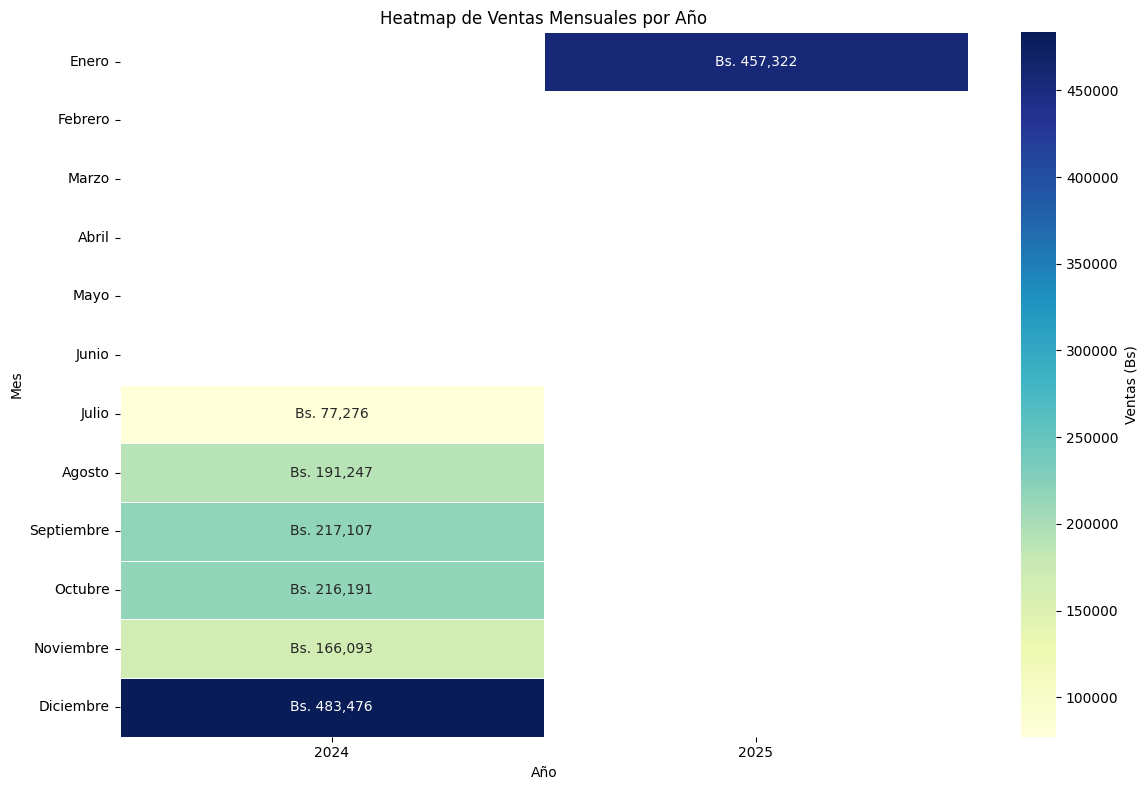


Resumen de ventas mensuales:
Total global: Bs. 1,808,712.00
Media mensual: Bs. 258,387.43
Mes con mayor venta: Diciembre 2024 (Bs. 483,476.00)
Mes con menor venta: Julio 2024 (Bs. 77,276.00)

3. ANALIZANDO CRECIMIENTO...

=== ANÁLISIS DE CRECIMIENTO ===



Estadísticas de crecimiento:
Cambio porcentual promedio: 53.8%
Meses con crecimiento: 3 (50.0%)
Meses con decrecimiento: 3 (50.0%)

Mayor crecimiento: Diciembre 2024 (+191.1%)
Mayor caída: Noviembre 2024 (-23.2%)

4. PREPARANDO MODELO...

=== PREPARANDO DATOS CON ESTACIONALIDAD ESPECÍFICA DE BOLIVIA ===
- Usando 3 características adaptadas al mercado escolar boliviano
- 7 observaciones disponibles

=== ENTRENANDO MODELO ROBUSTO PARA POCOS DATOS ===
- Regresión Lineal Simple: RMSE = Bs. 51,768.99, R² = 0.8656
- Ridge (alpha=0.1): RMSE = Bs. 54,864.55, R² = 0.8490
- Ridge (alpha=1.0): RMSE = Bs. 56,934.58, R² = 0.8374

Mejor modelo: Regresión Lineal Simple
- RMSE: Bs. 51,768.99
- R²: 0.8656

Coeficientes del modelo:
         Variable    Coeficiente
0          tiempo -215199.257143
1       tiempo_sq  314805.349439
2  temporada_alta   51707.258776

5. PREDICIENDO VENTAS PARA 12 MESES...

=== PREDICIENDO VENTAS PARA 12 MESES (MODELO ESCOLAR BOLIVIA) ===
Datos de referencia:
- Último valor:


=== DEMO: PREDICCIONES POR CATEGORÍA DE PRODUCTOS ===

Predicción por categoría (Escenario Esperado):
MES/AÑO      | Útiles Esc | Mochilas y | Libros y T | Electrónic | TOTAL
--------------------------------------------------------------------------------
Feb 2025     | Bs. 322,468 | Bs. 232,549 | Bs. 148,831 | Bs. 102,321 | Bs. 806,169
Mar 2025     | Bs. 206,710 | Bs. 129,194 | Bs. 134,361 | Bs. 77,516 | Bs. 547,781
Abr 2025     | Bs. 148,831 | Bs. 93,019 | Bs. 74,416 | Bs. 55,812 | Bs. 372,078
May 2025     | Bs. 140,563 | Bs. 87,852 | Bs. 70,281 | Bs. 42,169 | Bs. 340,865
Jun 2025     | Bs. 148,831 | Bs. 93,019 | Bs. 74,416 | Bs. 55,812 | Bs. 372,078
Jul 2025     | Bs. 51,188 | Bs. 24,883 | Bs. 31,281 | Bs. 21,328 | Bs. 128,680
Ago 2025     | Bs. 92,372 | Bs. 57,733 | Bs. 46,186 | Bs. 34,640 | Bs. 230,931
Sep 2025     | Bs. 132,001 | Bs. 82,501 | Bs. 66,001 | Bs. 49,500 | Bs. 330,003
Oct 2025     | Bs. 145,280 | Bs. 90,800 | Bs. 72,640 | Bs. 54,480 | Bs. 363,201
Nov 2025     | Bs. 1


¡ANÁLISIS COMPLETADO CON ÉXITO!


In [31]:
# SCRIPT PRINCIPAL CORREGIDO

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
warnings.filterwarnings('ignore')

def calcular_ventas_mensuales_directo(ruta_ventas='ventas.csv'):
    """
    Calcula ventas mensuales directamente del archivo CSV de ventas
    sin procesamiento complejo ni joins
    """
    print("\n=== CALCULANDO VENTAS MENSUALES DIRECTAMENTE ===")

    # Cargar datos
    try:
        df = pd.read_csv(ruta_ventas)
        print(f"Archivo cargado: {len(df)} registros")
        print(f"Total global en ventas: Bs. {df['total'].sum():,.2f}")
    except Exception as e:
        print(f"ERROR al cargar el archivo: {e}")
        return None

    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['createdAT'])

    # Extraer año y mes
    df['año'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month

    # Agrupar por año y mes, y sumar la columna total
    ventas_mensuales = df.groupby(['año', 'mes'])['total'].sum().reset_index()

    # Añadir nombre del mes
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
             7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
    ventas_mensuales['nombre_mes'] = ventas_mensuales['mes'].map(meses)

    # Ordenar por año y mes
    ventas_mensuales = ventas_mensuales.sort_values(['año', 'mes'])

    # Crear columnas necesarias para visualizaciones
    ventas_mensuales['año_mes'] = ventas_mensuales['año'].astype(str) + '-' + ventas_mensuales['mes'].astype(str).str.zfill(2)

    # Mostrar resultados
    print("\n=== TOTALES MENSUALES DE VENTAS (CÁLCULO DIRECTO) ===")
    print("=======================================================")
    total_general = 0

    for _, row in ventas_mensuales.iterrows():
        print(f"{row['nombre_mes']:10} {row['año']} | Bs. {row['total']:,.2f}")
        total_general += row['total']

    print("=======================================================")
    print(f"TOTAL GENERAL: Bs. {total_general:,.2f}")

    # Agregar columnas adicionales que espera visualizar_ventas_mensuales
    if 'num_ventas' not in ventas_mensuales.columns:
        # Contar número de ventas por mes (opcional)
        ventas_por_mes = df.groupby(['año', 'mes']).size().reset_index(name='num_ventas')
        ventas_mensuales = pd.merge(ventas_mensuales, ventas_por_mes, on=['año', 'mes'], how='left')

    # Calcular ticket promedio si hay ventas
    ventas_mensuales['ticket_promedio'] = ventas_mensuales['total'] / ventas_mensuales['num_ventas']
    ventas_mensuales['ticket_promedio'] = ventas_mensuales['ticket_promedio'].fillna(0)

    return ventas_mensuales

# Función principal
def main():
    print("1. CARGANDO Y CALCULANDO VENTAS MENSUALES...")
    ventas_mensuales = calcular_ventas_mensuales_directo('ventas.csv')

    if ventas_mensuales is not None:
        # Visualización
        print("\n2. VISUALIZANDO DATOS...")
        visualizar_ventas_mensuales(ventas_mensuales)

        # Análisis de crecimiento
        if len(ventas_mensuales) >= 2:
            print("\n3. ANALIZANDO CRECIMIENTO...")
            analizar_crecimiento(ventas_mensuales)

        # Modelado con enfoque mejorado
        print("\n4. PREPARANDO MODELO...")
        X, y, caracteristicas, columnas_modelo = preparar_datos_modelo_estacional_bolivia(ventas_mensuales)

        if X is not None and y is not None:
            # Entrenar modelo
            resultados_modelo = entrenar_modelo_regresion(X, y)

            # Predecir ventas futuras ///// AQUI PARAMETRO
            meses_a_predecir = 12
            print(f"\n5. PREDICIENDO VENTAS PARA {meses_a_predecir} MESES...")
            predicciones = predecir_ventas_realistas(
                resultados_modelo, ventas_mensuales, meses_a_predecir
            )

            # Visualizar predicciones con función corregida
            print("\n6. VISUALIZANDO PREDICCIONES...")
            visualizar_predicciones_conectadas(ventas_mensuales, predicciones)

            predicciones_categorias = predecir_ventas_por_categoria(predicciones)


            print("\n¡ANÁLISIS COMPLETADO CON ÉXITO!")
    else:
        print("ERROR: No se pudieron calcular las ventas mensuales")

# Para ejecutar el script
if __name__ == "__main__":
    main()